# Extension : Figure 2 with Stack Overflow

## Libraries
- bq_helper : Api to simplify use of BigQuery Api, used to do queries and store result in a dataframe
- pandas : to perform operations on dataframes
- matplotlib : for plotting our values
- numpy : for list operations
- os : to set environmental variables
- geopy : to geoencode adresses of users in coordinates
- timezonefinder : to transforme coordinates in timezones
- datetime : to transform fields in datetime
- pytz : to transform coordinates in utc offsets
- random : to make a random selection in the dataset
- mpld3 : transform a pyplot graph into a html file

In [1]:
import bq_helper
from bq_helper import BigQueryHelper
import geopy
from geopy.geocoders import *
from geopy.extra.rate_limiter import RateLimiter
import pandas as pd
from timezonefinder import TimezoneFinder
import datetime, pytz
import numpy as np
import matplotlib.pyplot as plt
import random
import mpld3
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="My Project 17425-755a3d361b77.json"

## Step 1 : Loading the data

The dataset we were using is a public dataset on the BigQuery application administered by Google. To access the dataset we use the Bq Helper API. As input we can give our SQL query to the database, and we have as output a dataframe containing the requested information. To create our graphs we will load user data as well as data of all comments

In [2]:
# Initialization of the object allowing us to make queries to the BibQuery api
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")

In [40]:
# SQL query to retrieve users ids and their location
query_users = """SELECT
  id, location
FROM
  `bigquery-public-data.stackoverflow.users`
        """
## Call to load the result of the query in a dataframe.
df_users = bq_assistant.query_to_pandas(query_users)

In [41]:
# SQL query to retrieve comments ids, user id associated, and creation date of the comments
query_comments = """SELECT
  id, user_id, creation_date
FROM
  `bigquery-public-data.stackoverflow.comments`
        """
## Call to load the result of the query in a dataframe.
df_comments = bq_assistant.query_to_pandas(query_comments)

In [42]:
df_users

,id,location
0,11821986,Bangladesh
1,11254763,Croatia
2,12269505,France
3,13876367,Global
4,2030188,"Palo Alto, CA"
...,...,...
13566770,1625555,India
13566771,8730223,India
13566772,7647683,India
13566773,11280659,India


In [43]:
df_comments

,id,user_id,creation_date
0,115121359,14559682.0,2020-12-02 22:04:20.613000+00:00
1,115121369,14751160.0,2020-12-02 22:04:44.813000+00:00
2,115121375,2704089.0,2020-12-02 22:05:06.053000+00:00
3,115121379,14531220.0,2020-12-02 22:05:13.413000+00:00
4,115121399,9297580.0,2020-12-02 22:06:08.407000+00:00
...,...,...,...
78005038,8853971,655187.0,2011-09-07 21:31:16.353000+00:00
78005039,8854028,319878.0,2011-09-07 21:34:17.253000+00:00
78005040,8854033,933627.0,2011-09-07 21:34:34.103000+00:00
78005041,8854035,237838.0,2011-09-07 21:34:36.523000+00:00


## Step 2 : Filtering the data

We will produce graphs showing user activity by day and hour. In order to be able to transform the creation dates of the comments into local time, we need to keep only the comments associated with a user with a defined location. To do so, firstly we will only keep users with a defined location, afterward we will only keep comments associated with one of those users


In [44]:
# In order to keep only the users with a defined location, we will drop the rows with na
df_users.dropna(inplace=True)

# In order to keep only comments from users with defined location
df_comments = df_comments[df_comments.user_id.isin(df_users.id.values)]

## Step 3 : Processing

Now that we have our raw data, we can process our data for the plots. The data processing is done in several steps, our final goal is to have a data frame with each line corresponding to a tweet with the associated information, including the time of publication in local time and not in UTC. We are going to sample the list of users and only be interested in the activity of this sample of users. The processing being expensive, we can't do it on all users. We are going to take the equivalent of 2% of the users, which still represents more than 20,000 users, i.e. much more than in our initial paper.

The different stages of processing are as follows:

- Randomly sample the list of users id.
- Take in the dataframes of the users and comments only the data relating to the id users present in our sampled list.
- Transform users' addresses into GPS coordinates, and discard users whose coordinates cannot be found.
- Transform the GPS coordinates into a timezone.
- Transforming timezones into utc offset.
- Merges the dataset containing the users' utc offset and the one containing the comments, so that we can have the offset of each comment.
- Transformation of the different date fields into datetime.
- Adding the offset to the date to get the date of the comment in local time.
- Addition of two columns, one containing the day of publication of the comment and the other containing the hour of publication of the tweet.
- We group according to day and hour for graph 2a and we group according to the same criteria for graph 2b, taking care to keep only one entry per user for each day and hour.


In [45]:
# Create list of users with at least one comment by creating a list based on the set if user ids in comment dataframe
users_with_comments = list(set(df_comments.user_id.values))
len(users_with_comments)*0.02

22535.2

In [49]:
# Random sampling of users
sampled_list = random.sample(users_with_comments, 22535)

In [50]:
# Take in our dataframes only the data related to users prensent in our sampled list
comments = df_comments[df_comments.user_id.isin(sampled_list)].copy()
users = df_users[df_users.id.isin(sampled_list)].copy()

In [51]:
# Creation of locator with geopy library, change the subscription key when run on local, timeout at 10 to avoid http exception
locator = AzureMaps(user_agent="myGeocoder",subscription_key='yzufoIvgzkQbe9YP-v3UdJnrySJPG_qgTxNe04KZTKg',timeout=10)

# RateLimiter on our locator, with minimal delay to speed up results
geocode = RateLimiter(locator.geocode, min_delay_seconds=0.1)

# Add in users whole address of the user and its coordinates
users['address'] = users['location'].apply(geocode)

# Drop rows where geocoding failed and we don't have an address
users.dropna(inplace=True)

# Extract coordinates from adress
users['point'] = users['address'].apply(lambda loc: tuple(loc.point) if loc else None)

In [53]:
users

,id,location,address,point
126,9466396,"Bokaro Steel City, Jharkhand, India","(Jamshedpur Tata Steel City, Jharkhand, (22.77...","(22.77901, 86.20391, 0.0)"
151,10661123,"230 Felton Avenue, Collingdale, PA, USA","(230 Felton Avenue, Collingdale, PA 19023, (39...","(39.91388, -75.27566, 0.0)"
189,561385,"Seville, Spain","(Seville, (37.38264, -5.9963))","(37.38264, -5.9963, 0.0)"
214,5629554,shillong,"(Shillong, Meghalaya, (25.57623, 91.88286))","(25.57623, 91.88286, 0.0)"
319,8564714,Estonia,"(Estonia, (59.44269, 24.7532))","(59.44269, 24.7532, 0.0)"
...,...,...,...,...
13565541,2049626,India,"(India, (28.63243, 77.21879))","(28.63243, 77.21879, 0.0)"
13565684,138562,India,"(India, (28.63243, 77.21879))","(28.63243, 77.21879, 0.0)"
13565784,5575246,India,"(India, (28.63243, 77.21879))","(28.63243, 77.21879, 0.0)"
13565785,12017671,India,"(India, (28.63243, 77.21879))","(28.63243, 77.21879, 0.0)"


In [54]:
# Tranform point in discrete coordinates, we add columns to users dataframe
users[['latitude','longitude', 'altitude']] = pd.DataFrame(users['point'].tolist(),index=users.index)

# Create timezoneFinder object
tf = TimezoneFinder()

# First get timezone of the user by applying timezonefinder on coordinates and afterward get the corresponding utc_offset of the timezone
users['timezone'] = users.apply(lambda row: tf.timezone_at(lng=row.longitude, lat=row.latitude), axis=1)
users['utc_offset'] = users.timezone.apply(lambda x : datetime.datetime.now(pytz.timezone(x)).strftime('%z'))

In [55]:
# Rename columns for clarity and merge on same column name 
users_utc_offset = users[['id','utc_offset']].rename(columns={"id":"user_id"})

In [56]:
# Merge comments and users dataframe to get utc offset of each comment
df_timeline = pd.merge(left=comments,right=users_utc_offset,on='user_id')

In [57]:
# We convert our fields containing dates in string format to datetime format using pd.to_datetime
df_timeline.creation_date = pd.to_datetime(df_timeline.creation_date,infer_datetime_format=True)
df_timeline.utc_offset = pd.to_datetime(df_timeline.utc_offset,format="%z").apply(lambda x : x.utcoffset())

# We add the offset to the datetime of creation of our tweet, we use add operation of dates
df_timeline.creation_date = df_timeline.creation_date + df_timeline.utc_offset

In [58]:
# We add the day name and the hour thanks to the built in methods of datetime objects
df_timeline['dayOfWeek'] = df_timeline['creation_date'].dt.day_name()
df_timeline['hour'] = df_timeline['creation_date'].dt.hour

In [59]:
# For 2a we want tweets per hour according to the day, so we group according to dayOfWeek and hour and we count, reset_index is used to simplify slicing afterwards
df_2a = df_timeline.groupby(by=['dayOfWeek','hour'])['id'].count().reset_index()

# For 2b we want active users per hour according to the day, we drop duplicates on the various columns to have only one entry per user for a given day and hour 
# and then we group according to dayOfWeek and hour and we count, reset_index is used to simplify slicing afterwards
df_2b = df_timeline.drop_duplicates(subset=['user_id','dayOfWeek','hour']).groupby(by=['dayOfWeek','hour'])['id'].count().reset_index()

In [62]:
df_2a.to_csv('stackoverflow_2a.csv')
df_2b.to_csv('stackoverflow_2b.csv')

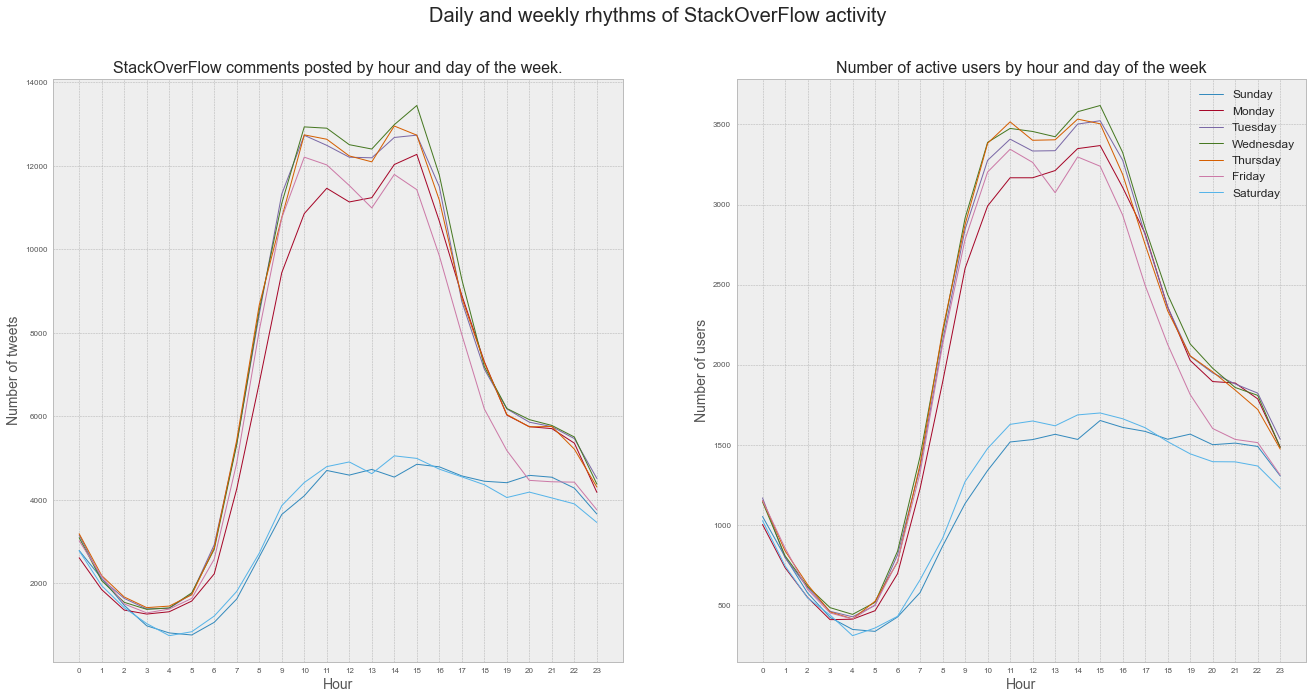

In [63]:
# List of days and hours, on which we iterate to plot data for each day and hour
days = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
hours = range(0,24,1)

# Grid with 2 plots, our graphs share the same x axis (list of hours)
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10), sharex = True)

for day in days:  
    
    # We slice on the data of our dataframes to recover only the data related to the day we are interested in.
    df_day_tweets = df_2a[df_2a.dayOfWeek == day]
    df_day_users = df_2b[df_2b.dayOfWeek == day]
    
    # We retrieve the count of active tweets/users after selecting only the day we are interested in.
    y_tweets = df_day_tweets.id
    y_users = df_day_users.id
    
    # Widht is set to q for clarity, we use plot to have a simple lineplot, the legend is the day 
    ax1.plot(hours,y_tweets,label=day,linewidth=1)
    ax2.plot(hours,y_users,label=day,linewidth=1)
    

# We define all the information specific to each subplot, the title of the subplot, and the labels of the x and y axes.     
ax1.set_title("StackOverFlow comments posted by hour and day of the week.",fontsize=16)
ax2.set_title("Number of active users by hour and day of the week",fontsize=16)   
ax1.set_xlabel('Hour',fontsize=14)
ax2.set_xlabel('Hour',fontsize=14)
ax1.set_ylabel('Number of tweets',fontsize=14)
ax2.set_ylabel('Number of users',fontsize=14)
    
# We define all information common to both graphs, the global title, the display and positioning of the legend, and the format of the x ticks.
plt.legend(fontsize=12)
plt.xticks(np.arange(0, 24, step=1))
plt.suptitle('Daily and weekly rhythms of StackOverFlow activity',fontsize=20)

plt.show()

## Extra : When to ask a question on stack overflow

We use bigquery to get an answer to this question. The query takes place in several stages all the questions are taken and grouped according to hours and days. Afterward we join the questions and the answers in our dataset keeping only the answers whose date is less than the date of the question + 1 hour. We order them by hour publication and day of publication. Once we have all the needed data we can plot it.

In [ ]:
# Sql query for get the data through bigquery
query = """SELECT
  question_hour,
  question_day,
  COUNT(answer_id) as count_answers,
  COUNT(question_id) as count_questions,
  ROUND(COUNT(answer_id)/COUNT(question_id)*100,2) as percent_questions
FROM
  (SELECT
    EXTRACT(hour from q.creation_date) as question_hour,
    q.accepted_answer_id as answer_id,
    q.id as question_id,
    EXTRACT(DAYOFWEEK FROM q.creation_date) as question_day
   FROM 
    `bigquery-public-data.stackoverflow.posts_questions` q
   FULL JOIN
    `bigquery-public-data.stackoverflow.posts_answers` a ON q.id = a.parent_id
   WHERE
     a.creation_date < TIMESTAMP_ADD(q.creation_date, INTERVAL 1 hour)) 
GROUP BY
  question_day, question_hour
ORDER BY 
  question_day, question_hour
        """
# We load all the data thanks to bq_assistant
df_percent_response = bq_assistant.query_to_pandas(query)

In [69]:
# We modify the value to get the right correspondance between days in our dataframe and in our list
df_percent_response.question_day = df_percent_response -1

,question_hour,question_day,count_answers,count_questions,percent_questions
0,0,0,27729,39141,70.84
1,1,0,24348,34815,69.94
2,2,0,24034,34246,70.18
3,3,0,23330,33914,68.79
4,4,0,24211,35281,68.62
...,...,...,...,...,...
163,19,6,48030,68671,69.94
164,20,6,46061,65588,70.23
165,21,6,42137,59816,70.44
166,22,6,37632,53279,70.63


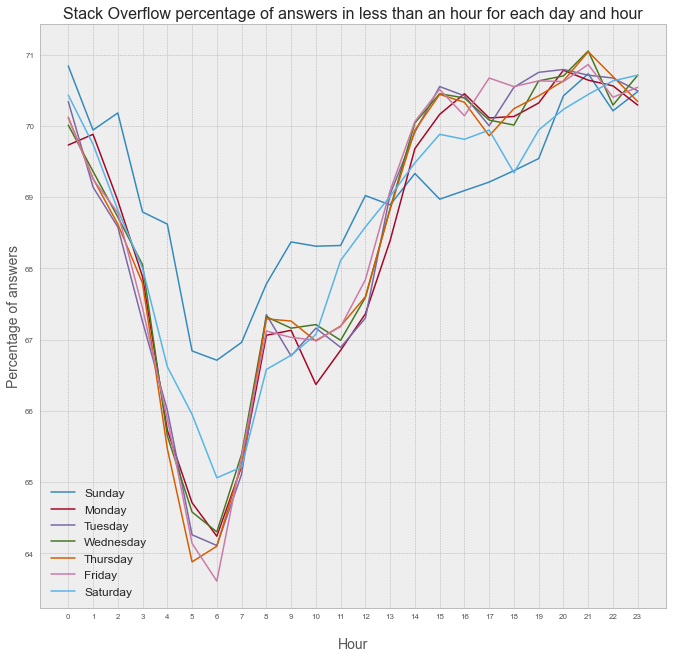

In [70]:
days = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
hours = range(0,24,1)
# Create our plot
plt.style.use('bmh')
f, ax = plt.subplots(1, 1,figsize=(10,10))

for n in range(0,7,1):  
    
    # We slice on the data of our dataframes to recover only the data related to the day we are interested in.
    df_day = df_percent_response[df_percent_response.question_day == n]
    
    # We retrieve the percentage responses only for the day we are interested in.
    y = df_day.percent_questions.values
    
    # Widht is set to q for clarity, we use plot to have a simple lineplot, the legend is the day 
    ax.plot(hours,y,label=days[n],linewidth=1.5)

    

# We define all the information specific to the plot, the title,the labels of the x and y axes, the display and positioning of the legend, and the format of the x ticks.
ax.set_title("Stack Overflow percentage of answers in less than an hour for each day and hour",fontsize=16)
ax.set_xlabel('Hour',fontsize=14)
ax.set_ylabel('Percentage of answers',fontsize=14)
ax.xaxis.set_label_coords(0.5, -0.05)
plt.legend(fontsize=12)
plt.xticks(np.arange(0, 24, step=1))


plt.show()